In [2]:
from systems.basesystem import System
from systems.positionsizing import PositionSizing
from systems.forecast_combine import ForecastCombine
from systems.forecast_scale_cap import ForecastScaleCap
from systems.trading_rules import TradingRule
from systems.forecasting import Rules
from systems.accounts.accounts_stage import Account
from systems.portfolio import Portfolios
from systems.rawdata import RawData
from systems.provided.rules.ewmac import ewmac, ewmac_calc_vol
from systems.provided.rules.breakout import breakout
from systems.provided.rules.accel import accel
from sysdata.sim.db_equities_sim_data import dbEquitiesSimData
from sysdata.config.configdata import Config

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    # miny, maxy = ax1.get_ylim()
    # ax1.set_ylim(miny+dy, maxy+dy)
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)


def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])


In [7]:
class MyPositionSizing(PositionSizing):

    def __init__(self, *args, long_only=False, **kwargs):
        self.__long_only = long_only
        super().__init__(*args, **kwargs)

    def get_subsystem_position(self, instrument_code: str) -> pd.Series:
        subsystem_position = super().get_subsystem_position(instrument_code)
        if self.__long_only:
            subsystem_position[subsystem_position < 0] = 0
        return subsystem_position

In [8]:
rules = Rules(dict(
    mac4 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':4, 'Lslow':16}),
    mac8 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':8, 'Lslow':32}),
    mac16 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':16, 'Lslow':64}),
    mac32 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':32, 'Lslow':128}),
    mac64 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':64, 'Lslow':256}),

    normmom2 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':2, 'Lslow':8}),
    normmom4 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':4, 'Lslow':16}),
    normmom8 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':8, 'Lslow':32}),
    normmom16 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':16, 'Lslow':64}),
    normmom32 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':32, 'Lslow':128}),
    normmom64 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':64, 'Lslow':256}),
    
    breakout10 = TradingRule(breakout, [], {'lookback':10}),
    breakout20 = TradingRule(breakout, [], {'lookback':20}),
    breakout40 = TradingRule(breakout, [], {'lookback':40}),
    breakout80 = TradingRule(breakout, [], {'lookback':80}),
    breakout160 = TradingRule(breakout, [], {'lookback':160}),
    breakout320 = TradingRule(breakout, [], {'lookback':320}),

    accel16 = TradingRule(accel, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':16}),
    accel32 = TradingRule(accel, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':32}),
    accel64 = TradingRule(accel, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':64}),
))

instrument_weights = dict(
    IWD = 0.33,
    IWF = 0.33,
    EEM = 0.33,
    TLT = 0.2,
    IEF = 0.2,
    HYG = 0.2,
    LQD = 0.2,
    PFIX = 0.2,
    GLD = 0.5,
    BITO = 0.5,
    PDBC = 1,
    KRBN = 0.2,
)

instruments = list(instrument_weights.keys())

config = Config(['private.estimates.yaml'])

class MySystem:

    def __init__(self, name, long_only=False):
        system = System([rules, RawData(), ForecastScaleCap(), ForecastCombine(), MyPositionSizing(long_only=long_only), Account(), Portfolios()], data=dbEquitiesSimData(), config=config)
        system.config.start_date = '2020-07-17'
        system.config.notional_trading_capital = 1000000
        system.config.percentage_vol_target = 24
        system.config.instrument_weights = instrument_weights
        # system.config.instrument_div_multiplier = 1.9
        # system.config.use_instrument_div_mult_estimates = True
        # system.config.use_instrument_weight_estimates = True
        # system.config.use_forecast_scale_estimates = True
        # system.config.use_forecast_div_mult_estimates = True
        # system.config.use_forecast_weight_estimates = True
        system.config.capital_multiplier['func'] = 'syscore.capital.full_compounding'
        print(system.get_instrument_list())
        self.system = system
        self.name = name


    def plot_combined_forecasts(self):
        import math
        plt.rc('figure', figsize=(20, 20))

        n_instruments = len(instruments)
        dim = 4
        pos = (math.ceil(n_instruments/4), dim)

        fig, ax = plt.subplots(*pos)
        for i, instrument in enumerate(instruments):
            axis = ax[i//dim][i%dim]
            axis.set_title(instrument)
            self.system.combForecast.get_combined_forecast(instrument).plot(ax=axis, lw=3)

        plt.tight_layout()
        plt.show()

    def plot_account_curves(self):
        portfolio = self.system.accounts.portfolio_with_multiplier()
        fig, ax1 = plt.subplots()
        portfolio.percent.curve().plot(ax=ax1, color='orange')
        portfolio.percent.drawdown().plot(ax=ax1, color='red')
        ax2 = ax1.twinx()
        portfolio.curve().plot(ax=ax2)

        align_yaxis(ax1,ax2)
        # ax1.set_yticks(step=25)
        ax1.minorticks_on()
        plt.show()

    def display_stats(self):
        display(self.system.accounts.portfolio().percent.stats())

    def get_weights(self):
        def get_percent_portfolio_weight(instrument):
            return self.system.accounts.get_actual_position(instrument)*self.system.data.daily_prices(instrument)/self.system.accounts.get_actual_capital()

        weights = pd.DataFrame()
        for i in self.system.get_instrument_list():
            weights[i] = get_percent_portfolio_weight(i)

        return weights

    def display_weights(self):
        display(self.get_weights())

    def write_ibkr_rebalance_file(self):
        from sysbrokers.IB.utils import write_ibkr_rebalance_file
        weights = self.get_weights()
        current_weights = {k:v for k,v in zip(weights.columns, weights[-1:].values[0])}
        current_weights

        write_ibkr_rebalance_file(self.name, current_weights, leverage=1)



In [ ]:
mySystem = MySystem('trend_following_long_short_v1')
mySystem.plot_combined_forecasts()
mySystem.plot_account_curves()
mySystem.display_stats()
mySystem.display_weights()
mySystem.write_ibkr_rebalance_file()

True
2022-07-25 14:17:58 {'type': 'dbEquitiesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
['BITO', 'EEM', 'GLD', 'HYG', 'IEF', 'IWD', 'IWF', 'KRBN', 'LQD', 'PDBC', 'PFIX', 'TLT']
2022-07-25 14:18:03 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'IWD'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules in system
2022-07-25 14:18:48 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'IWF'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules in system
2022-07-25 14:18:48 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'EEM'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules in system
2022-07-25 14:18:49 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'TLT'} [Warning] WARNING: No forecast weights  - usi

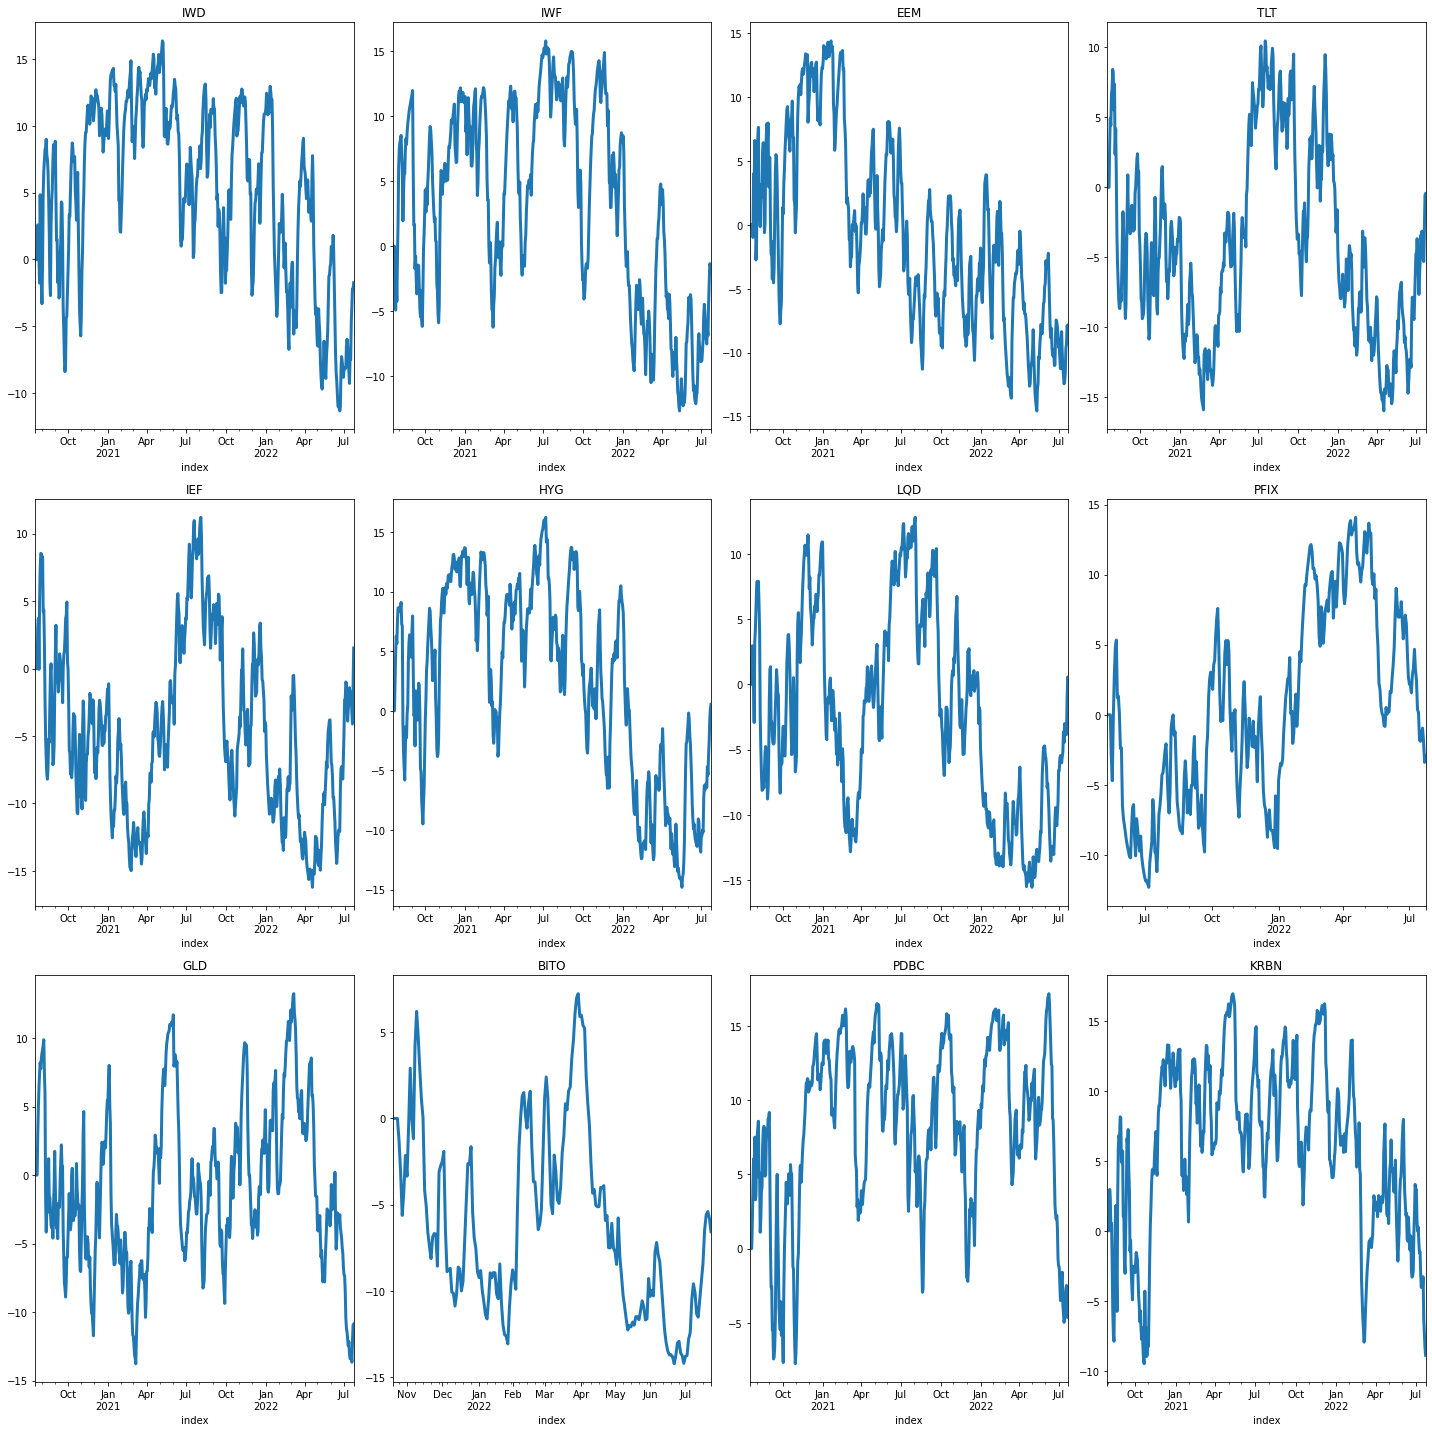

True index
2021-10-19             NaN
2021-10-20             NaN
2021-10-21             NaN
2021-10-22             NaN
2021-10-25             NaN
                  ...     
2022-07-19   -11052.972374
2022-07-20    -9724.690570
2022-07-21    -9577.536892
2022-07-22   -10423.967391
2022-07-25   -12009.614926
Freq: B, Length: 200, dtype: float64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [9]:
mySystem = MySystem('trend_following_long_only_v1', long_only=True)
mySystem.plot_combined_forecasts()
mySystem.plot_account_curves()
mySystem.display_stats()
mySystem.display_weights()
mySystem.write_ibkr_rebalance_file()

In [ ]:
import math
plt.rc('figure', figsize=(20, 20))

n_instruments = len(instruments)
dim = 4
pos = (math.ceil(n_instruments/4), dim)

fig, ax = plt.subplots(*pos)
for i, instrument in enumerate(instruments):
    axis = ax[i//dim][i%dim]
    axis.set_title(instrument)
    system.combForecast.get_combined_forecast(instrument).plot(ax=axis, lw=3)

plt.tight_layout()

In [ ]:
portfolio = system.accounts.portfolio_with_multiplier()
fig, ax1 = plt.subplots()
portfolio.percent.curve().plot(ax=ax1, color='orange')
portfolio.percent.drawdown().plot(ax=ax1, color='red')
ax2 = ax1.twinx()
portfolio.curve().plot(ax=ax2)

align_yaxis(ax1,ax2)
# ax1.set_yticks(step=25)
ax1.minorticks_on()
plt.show()


In [ ]:
portfolio.percent.stats()

In [ ]:
import pandas as pd

def get_percent_portfolio_weight(instrument):
    return system.accounts.get_actual_position(instrument)*system.data.daily_prices(instrument)/system.accounts.get_actual_capital()

weights = pd.DataFrame()
for i in system.get_instrument_list():
    weights[i] = get_percent_portfolio_weight(i)

weights



In [ ]:
from sysbrokers.IB.utils import write_ibkr_rebalance_file

current_weights = {k:v for k,v in zip(weights.columns, weights[-1:].values[0])}
current_weights

write_ibkr_rebalance_file('trend_following_long_short_v1', current_weights, leverage=1)

In [ ]:
from systems.diagoutput import systemDiag
from syscore.fileutils import get_filename_for_package

diag = systemDiag(system)
display(diag.output_config_with_estimated_parameters())

def save_estimated_system(system, package):
    filename=get_filename_for_package(package)
    sysdiag = systemDiag(system)
    sysdiag.yaml_config_with_estimated_parameters(filename,
                                                attr_names=['forecast_scalars',
                                                            'forecast_weights',
                                                            'forecast_div_multiplier',
                                                            'forecast_mapping',
                                                            'instrument_weights',
                                                            'instrument_div_multiplier'])

save_estimated_system(system, 'private.estimates-test.yaml')